<a href="https://colab.research.google.com/github/SoungbinC/CMPE_258/blob/assignment3/Assignment4_fastai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Vision object detection task

## Vision object detection task

### Load and prepare the dataset

In [61]:
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle (1).json


In [62]:
!pip install kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [63]:
!kaggle datasets download -d anirudhg15/bears-fastai-2021

bears-fastai-2021.zip: Skipping, found more recently modified local copy (use --force to force download)


In [64]:
!unzip -qo bears-fastai-2021.zip

In [65]:
from fastai.vision.all import *
from pathlib import Path
path = Path('/content/bears')
path.ls()

(#3) [Path('/content/bears/teddy'),Path('/content/bears/black'),Path('/content/bears/grizzly')]

In [66]:
def get_dls(bs, size):
    dblock = DataBlock(blocks = (ImageBlock, CategoryBlock),
                       get_items = get_image_files,
                       get_y = parent_label,
                       splitter = RandomSplitter(),
                       item_tfms = Resize(size)
                      )
    return dblock.dataloaders(path, bs = bs)

In [67]:
dls = get_dls(16, 128)

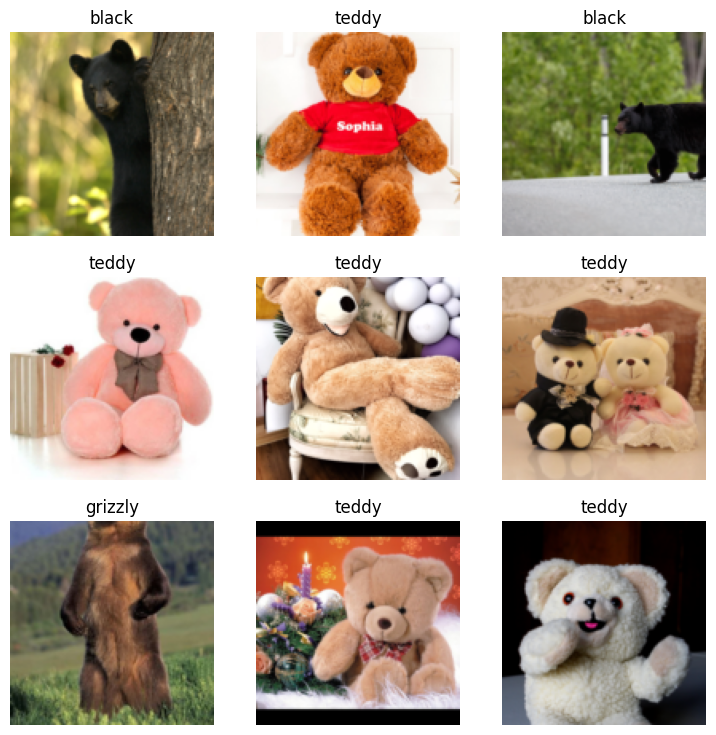

In [68]:
dls.show_batch()

### Train a model

In [69]:

learn = vision_learner(dls, resnet34, metrics=error_rate)


SuggestedLRs(valley=0.002511886414140463)

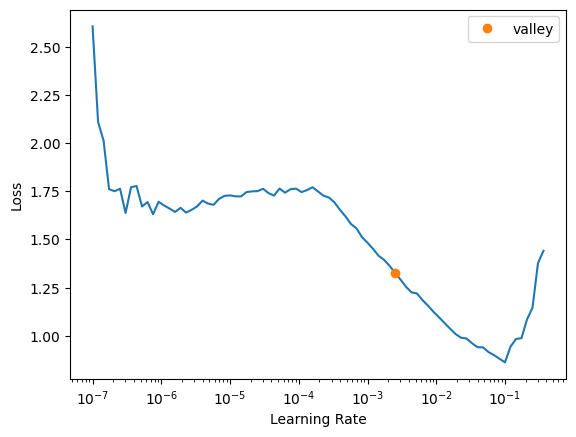

In [70]:
learn.lr_find()

In [71]:
learn = vision_learner(dls, resnet34, metrics=accuracy)
learn.fit_one_cycle(10, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.581336,0.370816,0.842105,00:08
1,0.962554,0.022631,1.000000,00:08
2,0.627865,0.008841,1.000000,00:07
3,0.482333,0.055934,0.964912,00:08
4,0.354276,0.035801,0.964912,00:07
5,0.279616,0.020470,1.000000,00:08
6,0.227424,0.043876,0.964912,00:08
7,0.184313,0.056614,0.964912,00:07
8,0.159138,0.072185,0.964912,00:07
9,0.127380,0.045448,0.964912,00:07


In [72]:
learn.dls = get_dls(16, 224)
learn.fine_tune(5, 1e-3)


epoch,train_loss,valid_loss,accuracy,time
0,0.044423,0.051604,0.982456,00:08


epoch,train_loss,valid_loss,accuracy,time
0,0.077336,0.022396,0.982456,00:07
1,0.064906,0.002616,1.000000,00:08
2,0.059382,0.007172,1.000000,00:08
3,0.052651,0.019391,0.982456,00:08
4,0.066871,0.023752,0.982456,00:09


### The result and Inference

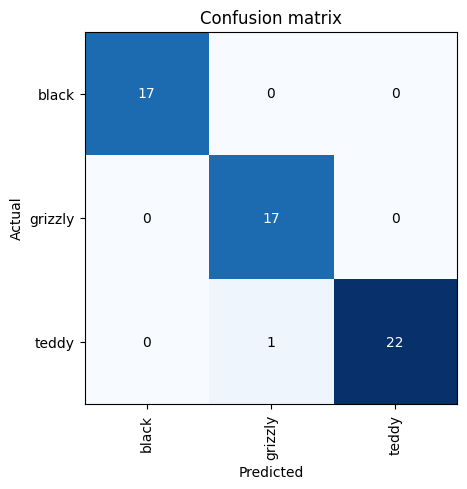

In [73]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

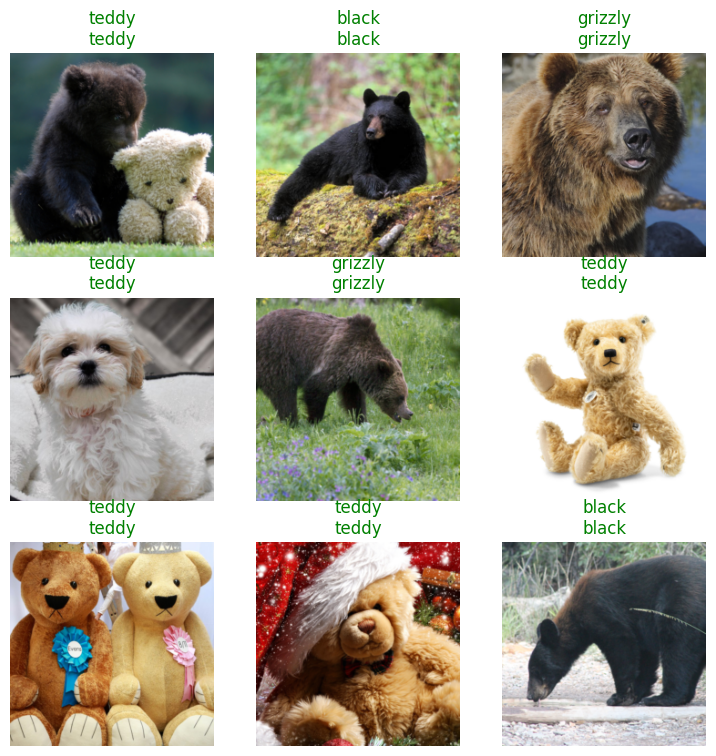

In [74]:
learn.show_results()

### Save the model

In [75]:
import os

models_dir = '/content/models'
os.makedirs(models_dir, exist_ok=True)
learn.export(f'{models_dir}/model_1.pkl')

### Reload the model

In [76]:
from fastai.learner import load_learner

# Path to your models directory
models_dir = '/content/models'

# Loading the models
model_1 = load_learner(f'{models_dir}/model_1.pkl')
model_1

### Predict with the model

In [77]:
model_1.predict('/content/bears/black/00000017.jpg')

('black', tensor(0), tensor([1.0000e+00, 1.6947e-07, 6.4183e-07]))

## Vision Segmentation Task

### Load and prepare the dataset

In [78]:
def label_func(o):
    return path/'labels'/f'{o.stem}_P{o.suffix}'

path = untar_data(URLs.CAMVID_TINY)
dls = SegmentationDataLoaders.from_label_func(
    path, bs=8, fnames=get_image_files(path/"images"),
    label_func=label_func,
    codes=np.loadtxt(path/'codes.txt', dtype=str)
)

### Train a model


In [79]:
learn2 = unet_learner(dls, resnet34)
learn2.fine_tune(8)


epoch,train_loss,valid_loss,time
0,3.001269,2.517359,00:02


epoch,train_loss,valid_loss,time
0,1.899534,1.482426,00:02
1,1.652434,1.508029,00:02
2,1.487053,1.193874,00:02
3,1.343907,1.003906,00:02
4,1.206487,0.903696,00:02
5,1.083805,0.848145,00:02
6,0.986326,0.822762,00:02
7,0.910184,0.813498,00:02


### Inference and result metrics

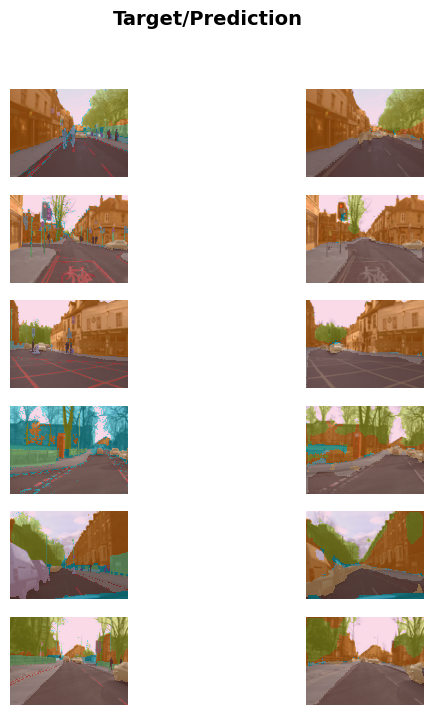

In [80]:
learn2.show_results(max_n=6, figsize=(7,8))


### Save the model

In [81]:
import os

models_dir = '/content/models'
os.makedirs(models_dir, exist_ok=True)

In [82]:
learn2.export(f'{models_dir}/model_2.pkl')

### Reload the model

In [83]:
model_2 = load_learner(f'{models_dir}/model_2.pkl')
model_2